# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
import xlrd
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [11]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [12]:
#your turn
new_data = df_transactions[['customer_name', 'offer_id', 'n']].merge(df_offers[['offer_id']], how='inner', on=['offer_id'])

In [13]:
new_d = new_data.pivot_table(index = 'customer_name', columns = 'offer_id', values = 'n')

In [14]:
new_d = new_d.fillna(0)

**The dataframe is now ready for operation. The NaN values were filled with 0.**

In [15]:
new_d.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [9]:
# your turn


**Initially, if the clusters are placed very far away from the data points, their associated SS values will be very high as the distance between the clusters and the data points is huge. The clusters start moving closer to the data points such that each cluster becomes a center for a "cluser" of data points. The realighment of clusters stops for the least possible value of SS.**

**In this part of the exercise, we will use the elbow method to intuitively determine from the plot what the best value of K should be.**

**We will start with converting our pandas dataframe to a numpy matrix.**

In [16]:
cust_data = new_d.values

In [17]:
type(cust_data)

numpy.ndarray

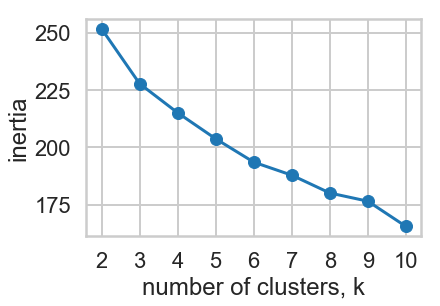

In [18]:
from sklearn.cluster import KMeans
ks = range(2, 11)
inertias = []
k_dict = {} #This dictionalry will contain all the labels fo each K.

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(cust_data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    j = model.labels_.tolist()
    k_dict[k] = j
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**From the above plot, we can choose K = 5 as our best value as the change in inertia starts decreasing steadily.**

**We now convert the list containing values for K = 5 and then plot the counts for each label.**

In [11]:
a1 = np.array(k_dict[5])

Text(0.5, 0, 'Labels')

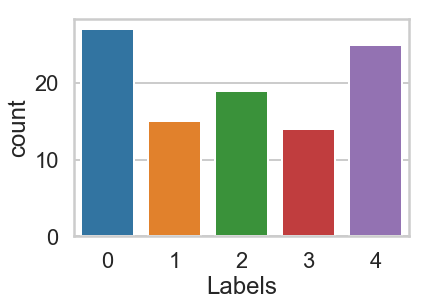

In [12]:
sns.countplot(a1)
plt.xlabel('Labels')

**The major drawback of the elbow method is that, ultimately, we have to decide on the best value of K based on our intuition. Moreover, in K-means clustering, the clusters are initially placed at random. Hence, they dont always converge to the same SS values each time. The SS values vary for different starting positions of clusters. As a result, our intuition for choosing the best value of K may differ if the algorithm is run multiple times.**

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [14]:
# Your turn.


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09365573283492713


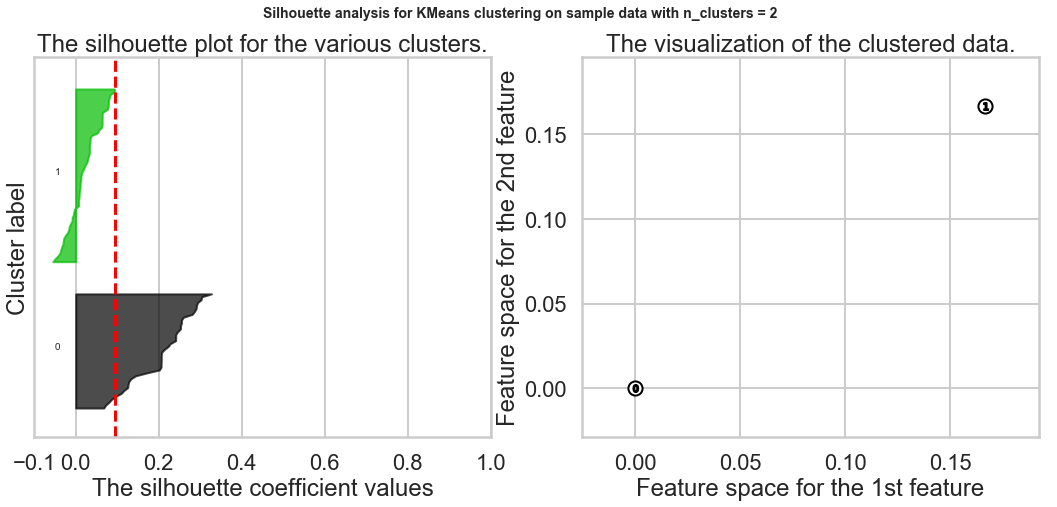

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


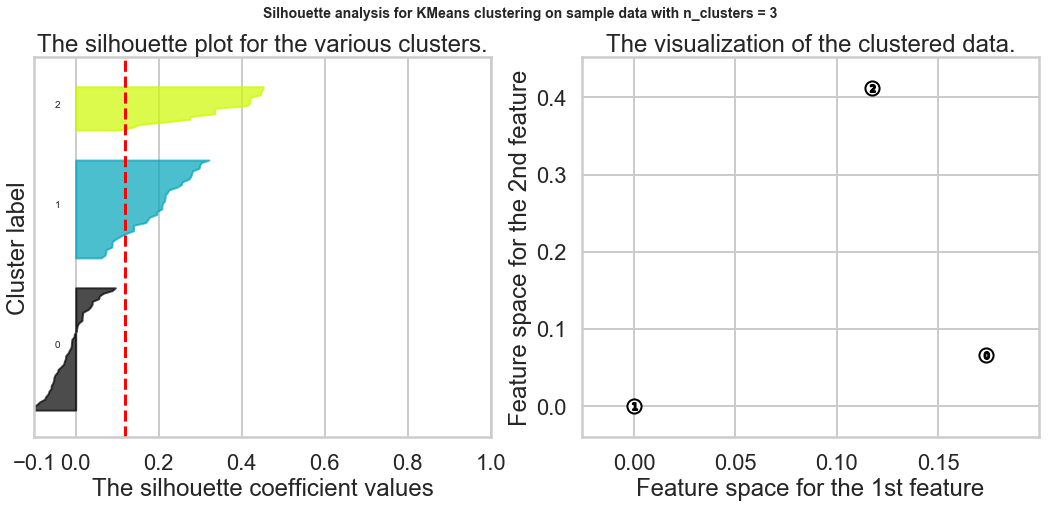

For n_clusters = 4 The average silhouette_score is : 0.12347053919571699


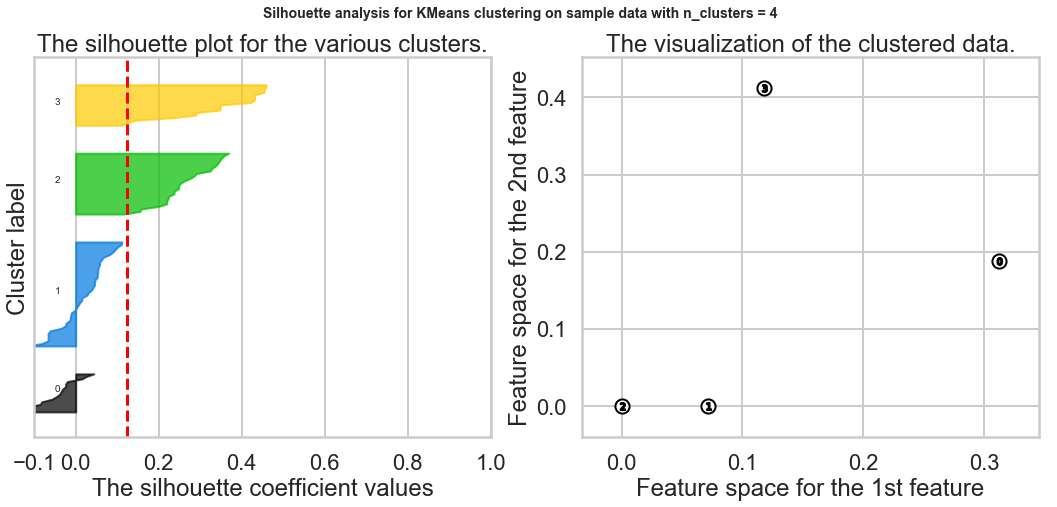

For n_clusters = 5 The average silhouette_score is : 0.14092516241984757


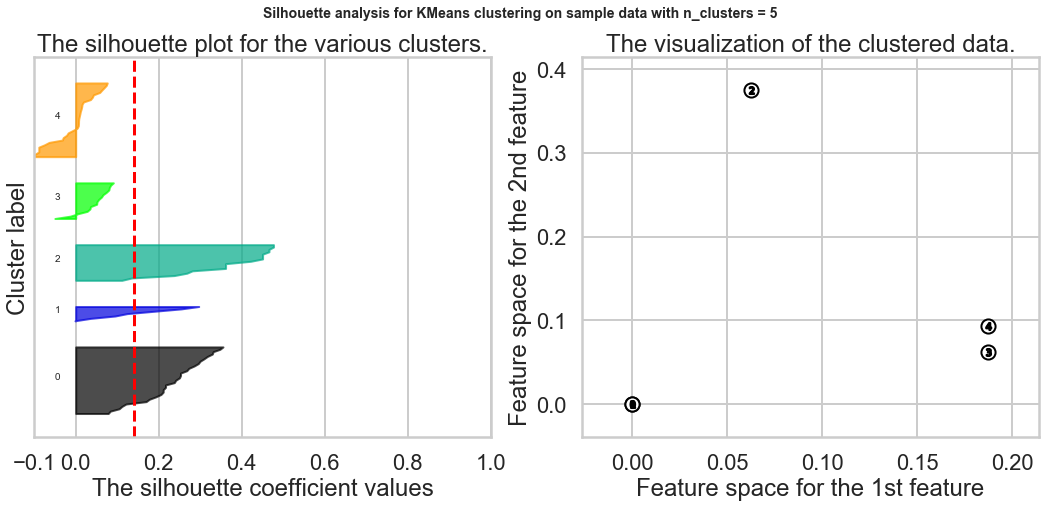

For n_clusters = 6 The average silhouette_score is : 0.1371798939109807


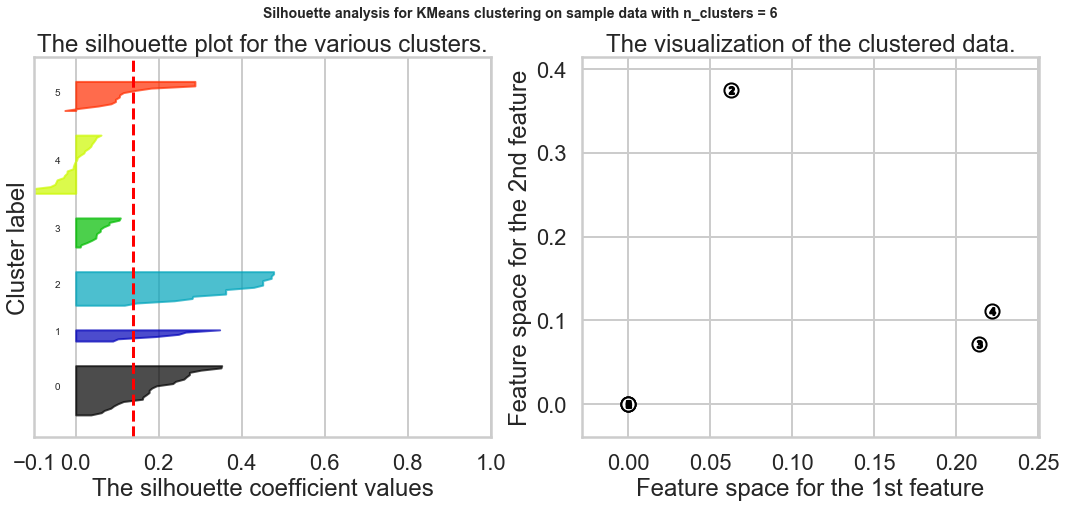

For n_clusters = 7 The average silhouette_score is : 0.1161092456616906


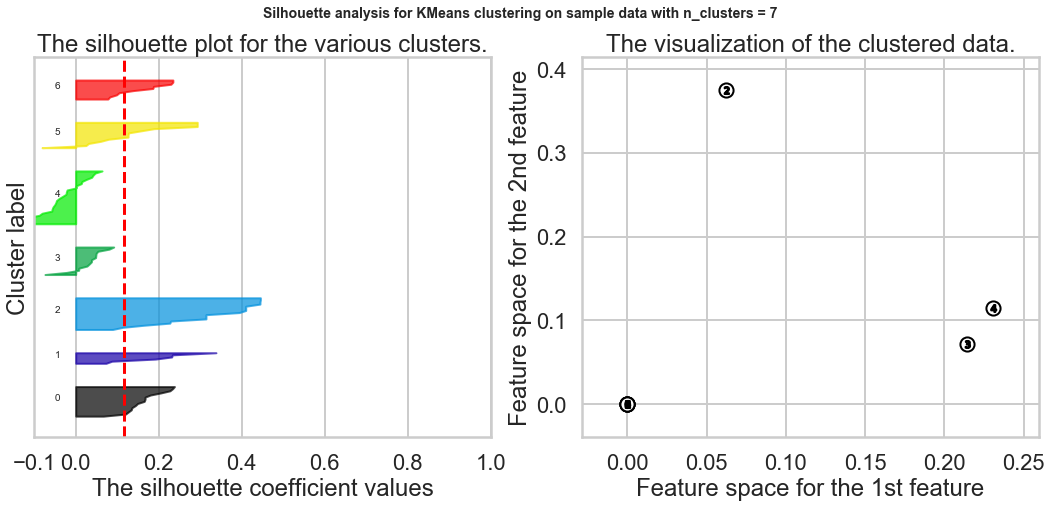

For n_clusters = 8 The average silhouette_score is : 0.11339573832632867


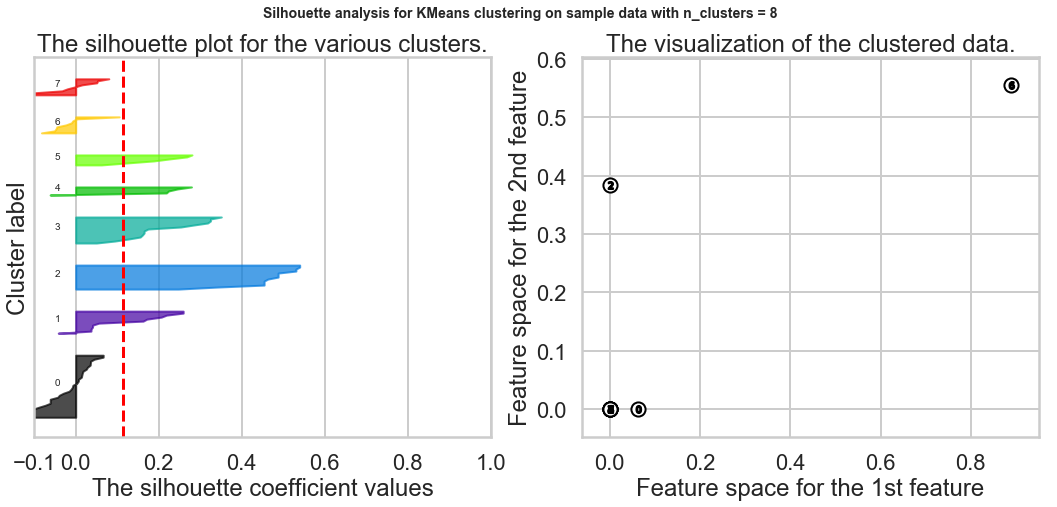

For n_clusters = 9 The average silhouette_score is : 0.12505960527779877


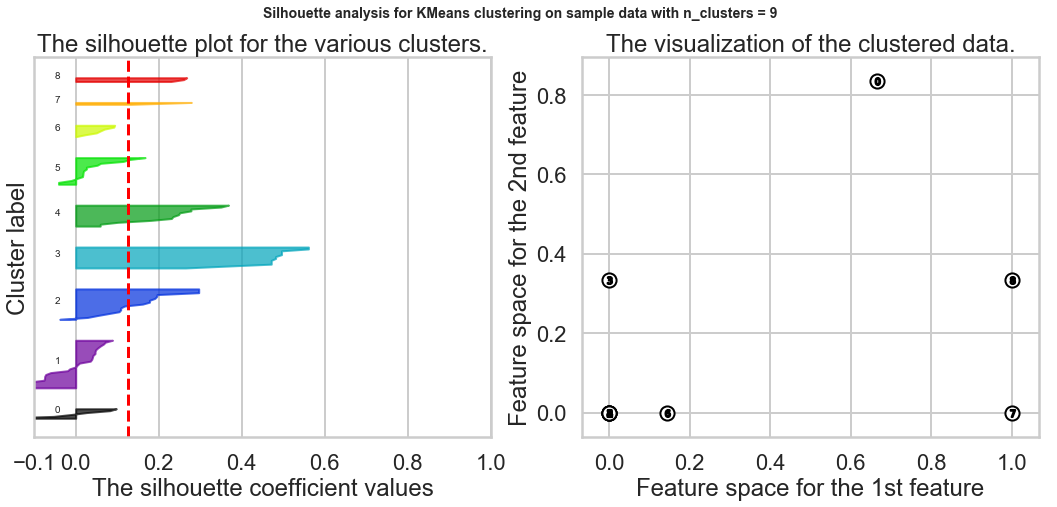

For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


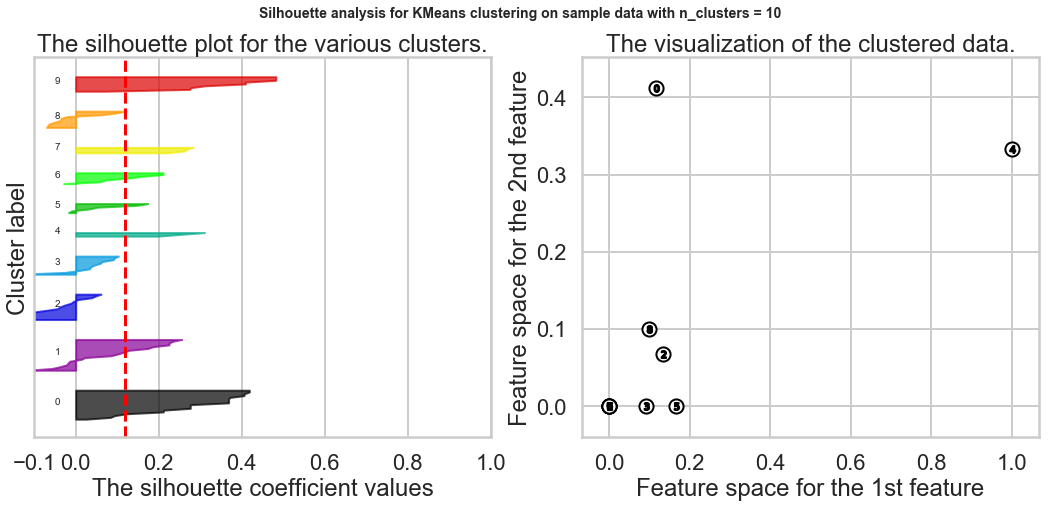

In [13]:
from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cust_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cust_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cust_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cust_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')    
    plt.show()

**The maximum silhouette_score is 0.1409 which is computed for K = 5. Our result doesn't differ from the K value that we interpreted was best using the elboe method.**

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [14]:
#your turn
from sklearn.decomposition import PCA

# Create PCA instance: model
model = PCA(n_components = 2)

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(cust_data)
# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]
kmeans = KMeans(n_clusters = 5, random_state = 42)
y_pred = a1

Text(0, 0.5, 'y component')

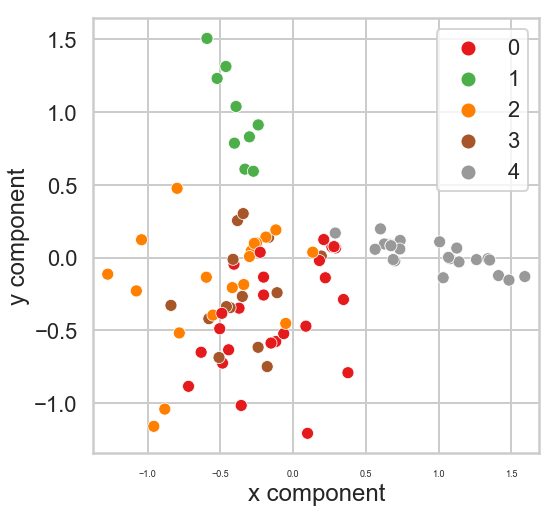

In [53]:
pca_df = {'x_component' : xs, 'y_component' : ys, 'labels_pred' : y_pred}

# Scatter plot xs vs ys
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x = 'x_component', y = 'y_component', hue = 'labels_pred', data = pca_df, palette = 'Set1', legend = 'full')
plt.axis('equal')
plt.xlabel('x component')
plt.ylabel('y component')

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [59]:
pca_dataframe = pd.DataFrame(pca_df)

**From the above plot, we the points divided baed on the different cluster labels.**

In [95]:
pca_dataframe[['labels_pred']] = pca_dataframe[['labels_pred']].astype('str')

**Now, we will concatenate the labels with the customer data set where each row represents a single customer and contains information about the wines purchased.**

In [102]:
joined_df = pd.concat([new_d.reset_index(), pca_dataframe[['labels_pred']]],axis = 1)

In [202]:
joined_df_label_1 = joined_df.loc[joined_df.labels_pred == '1'] #Pandas dataframe with label 1
joined_df_label_2 = joined_df.loc[joined_df.labels_pred == '2'] #Pandas dataframe with label 2
joined_df_label_3 = joined_df.loc[joined_df.labels_pred == '3'] #Pandas dataframe with label 3
joined_df_label_4 = joined_df.loc[joined_df.labels_pred == '4'] #Pandas dataframe with label 4
joined_df_label_0 = joined_df.loc[joined_df.labels_pred == '0'] #Pandas dataframe with label 0

In [186]:
label_1_counts = {} #This dictionary will be used to count the sales of wines based on offer ID for customers with label '1'

In [187]:
for j in range(1,33):
    if np.sum(joined_df_label_1[j])!= 0:
        label_1_counts[j] = np.sum(joined_df_label_1[j])
        

In [133]:
label_1_counts

{2: 5.0, 12: 1.0, 16: 1.0, 17: 7.0, 24: 12.0, 26: 11.0}

In [156]:
pd.DataFrame([label_1_counts])#.stack().sort_values(ascending = False)

,2,12,16,17,24,26
0,5.0,1.0,1.0,7.0,12.0,11.0


**The columns represent the offer_id's and the column values represent the number of purchases for that offer_id.**

**Now, let us subset the offers data frame to reflect the offer_id's with highest purchases for those with label '1'.**

In [5]:
df_offers.loc[(df_offers.offer_id == 24) | (df_offers.offer_id == 26) | (df_offers.offer_id == 17) | (df_offers.offer_id == 2)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


**From the above observations, we see that all the wines are of variety 'Pinot Noir' and they are past their peak. The past_peak characteristic may not be as important as the varietal feature but the classification algorithm seems to have separated the labels based on the 'past_peak' feature as well.**

In [168]:
label_2_counts = {}
for j in range(1,33):
    if np.sum(joined_df_label_2[j])!= 0:
        label_1_counts[j] = np.sum(joined_df_label_2[j])

**For the below dataframe, the first column represents the various offer_ids and the second column represents the number of times it was purchased.**

In [171]:
pd.DataFrame([label_1_counts]).stack().sort_values(ascending = False)

0  24    12.0
   9     10.0
   14     9.0
   17     7.0
   1      5.0
   23     5.0
   15     5.0
   22     5.0
   5      4.0
   26     4.0
   31     4.0
   6      4.0
   25     3.0
   27     3.0
   4      3.0
   11     3.0
   10     3.0
   16     2.0
   20     2.0
   30     2.0
   12     1.0
   2      1.0
   32     1.0
dtype: float64

**Now, we subset the rows from the df_offers dataframe for the most frequent purchases and try to relate the wine varieties.**

In [6]:
df_offers.loc[(df_offers.offer_id == 24) | (df_offers.offer_id == 9) | (df_offers.offer_id == 14) | (df_offers.offer_id == 17) | (df_offers.offer_id == 1) | (df_offers.offer_id == 15) | (df_offers.offer_id == 23)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
8,9,April,Chardonnay,144,57,Chile,False
13,14,June,Merlot,72,64,Chile,False
14,15,June,Cabernet Sauvignon,144,19,Italy,False
16,17,July,Pinot Noir,12,47,Germany,False
22,23,September,Chardonnay,144,39,South Africa,False
23,24,September,Pinot Noir,6,34,Italy,False


**The second label is a little more interesting. The wine varieties are a mix of white and red wines. All the wines here have a 'past_peak value' of 'False'. But that is not what we're interested in. All of the wine varieties mentioned are "dry" wines.**

In [188]:
label_3_counts = {}
for j in range(1,33):
    if np.sum(joined_df_label_3[j])!= 0:
        label_3_counts[j] = np.sum(joined_df_label_3[j])

**For the below dataframe, just as before, the first column represents the various offer_ids and the second column represents the number of times it was purchased. This methodology will be followed throughout for analyzing the clusters.**

In [190]:
pd.DataFrame([label_3_counts]).stack().sort_values(ascending = False)

0  11    9.0
   22    7.0
   28    5.0
   1     5.0
   31    4.0
   30    4.0
   2     4.0
   25    3.0
   12    3.0
   20    2.0
   4     2.0
   32    1.0
   29    1.0
   16    1.0
   15    1.0
dtype: float64

**Once again, we subset the df_offers dataframe to reflect the most frequent purchases so we can find a relation between the different wine varieties.**

In [194]:
df_offers.loc[(df_offers.offer_id == 11) | (df_offers.offer_id == 22) | (df_offers.offer_id == 28) | (df_offers.offer_id == 1) | (df_offers.offer_id == 31) | (df_offers.offer_id == 30) | (df_offers.offer_id == 2)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
10,11,May,Champagne,72,85,France,False
21,22,August,Champagne,72,63,France,False
27,28,November,Cabernet Sauvignon,12,56,France,True
29,30,December,Malbec,6,54,France,False
30,31,December,Champagne,72,89,France,False


**From the above dataframe, it would seem that the customers who were assigned class '3' by the algorithm, purchased wines originating in France.**

In [195]:
label_4_counts = {}
for j in range(1,33):
    if np.sum(joined_df_label_4[j])!= 0:
        label_4_counts[j] = np.sum(joined_df_label_4[j])

In [197]:
pd.DataFrame([label_4_counts]).stack().sort_values(ascending = False)

0  30    16.0
   29    16.0
   7     12.0
   18    11.0
   8     11.0
   13     6.0
   28     1.0
dtype: float64

In [8]:
df_offers.loc[(df_offers.offer_id == 30) | (df_offers.offer_id == 29) | (df_offers.offer_id == 18) | (df_offers.offer_id == 7) | (df_offers.offer_id == 8) | (df_offers.offer_id == 13)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
12,13,May,Merlot,6,43,Chile,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


**This is another interesting classification by the classification algorithm. What we have here is a mix of white and red wines. But, they all have the "min_qty" feature values of '6'.**

**Next, we repeat the same process for customers with label '0'.**

In [204]:
label_0_counts = {}
for j in range(1,33):
    if np.sum(joined_df_label_0[j])!= 0:
        label_0_counts[j] = np.sum(joined_df_label_0[j])

In [206]:
pd.DataFrame([label_0_counts]).stack().sort_values(ascending = False)

0  8     9.0
   22    9.0
   31    9.0
   6     8.0
   4     7.0
   7     7.0
   3     6.0
   27    6.0
   19    5.0
   21    4.0
   10    4.0
   18    3.0
   32    2.0
   20    2.0
   11    1.0
   12    1.0
   16    1.0
dtype: float64

In [10]:
df_offers.loc[(df_offers.offer_id == 8) | (df_offers.offer_id == 22) | (df_offers.offer_id == 31) | (df_offers.offer_id == 6) | (df_offers.offer_id == 4) | (df_offers.offer_id == 7) | (df_offers.offer_id == 27)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
21,22,August,Champagne,72,63,France,False
26,27,October,Champagne,72,88,New Zealand,False
30,31,December,Champagne,72,89,France,False


**Espumante is Portuguese Champagne while Prosecco, which is sparkling white wine could be broadly classified as a champagne. Hence, customers with label '0' are those who purchased champagne.**

**Let us now visualize this result by region and the associated centroids of each cluster.**

# <font color=red >Classification summary with 5 labels </font>

**`Label 0`** - Customers who predominatly purchased **`champagne`**.

**`Label 1`** - Customers who purchased **`Penot Noir`** wine.

**`Label 2`** - Customers who purchased **`dry wine`**.

**`Label 3`** - Customers who purchased wine varieties **`originating in France.`**

**`Label 4`** - Customers who purchased wines where the **`'min_qty' was 6.`**

**While, labels 0 through 3 have valuable information, Label 4 seemed rather "unnecessary".**

**Now, let us try the clustering alrithm with 4 clusters and explore further.**

Text(0, 0.5, 'Count')

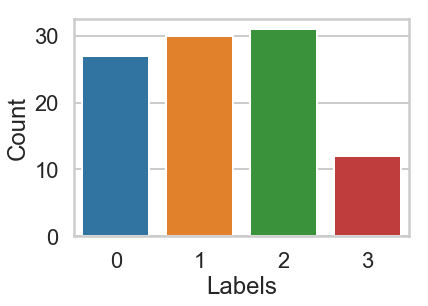

In [20]:
a2 = np.array(k_dict[4])
sns.countplot(a2)
plt.xlabel('Labels')
plt.ylabel('Count')

In [28]:
a2 = pd.DataFrame(a2)
a2.columns = ['Labels_pred']
a2.head()

,Labels_pred
0,0
1,2
2,3
3,0
4,1


In [55]:
joined_df_4_labels = pd.concat([new_d.reset_index(), a2[['Labels_pred']]],axis = 1)

In [56]:
joined_df_labels4_1 = joined_df_4_labels.loc[joined_df_4_labels.Labels_pred == 1] #Pandas dataframe with label 1
joined_df_labels4_2 = joined_df_4_labels.loc[joined_df_4_labels.Labels_pred == 2] #Pandas dataframe with label 2
joined_df_labels4_3 = joined_df_4_labels.loc[joined_df_4_labels.Labels_pred == 3] #Pandas dataframe with label 3
joined_df_labels4_0 = joined_df_4_labels.loc[joined_df_4_labels.Labels_pred == 0] #Pandas dataframe with label 0

In [69]:
labels4_1 = {}
for j in range(1,33):
    if np.sum(joined_df_labels4_1[j])!= 0:
        labels4_1[j] = np.sum(joined_df_labels4_1[j])

In [71]:
pd.DataFrame([labels4_1]).stack().sort_values(ascending = False)

0  22    20.0
   31    17.0
   6      8.0
   11     7.0
   4      6.0
   1      6.0
   3      5.0
   19     5.0
   27     4.0
   10     4.0
   7      4.0
   8      4.0
   30     4.0
   14     4.0
   28     3.0
   15     3.0
   9      3.0
   2      2.0
   32     2.0
   12     2.0
   20     2.0
   21     2.0
   23     2.0
   25     2.0
   18     1.0
   29     1.0
   16     1.0
dtype: float64

In [73]:
df_offers.loc[(df_offers.offer_id == 22) | (df_offers.offer_id == 31) | (df_offers.offer_id == 11) | (df_offers.offer_id == 6) | (df_offers.offer_id == 4) | (df_offers.offer_id == 19) | (df_offers.offer_id == 3) |(df_offers.offer_id == 27 | (df_offers.offer_id == 10))]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
10,11,May,Champagne,72,85,France,False
18,19,July,Champagne,12,66,Germany,False
21,22,August,Champagne,72,63,France,False
30,31,December,Champagne,72,89,France,False


**From the above dataframe, see that the customers with label '1' were purchasers of Champagne.**

In [74]:
labels4_2 = {}
for j in range(1,33):
    if np.sum(joined_df_labels4_2[j])!= 0:
        labels4_2[j] = np.sum(joined_df_labels4_2[j])

In [75]:
pd.DataFrame([labels4_2]).stack().sort_values(ascending = False)

0  26    7.0
   9     7.0
   4     6.0
   11    6.0
   14    5.0
   27    5.0
   16    4.0
   2     4.0
   5     4.0
   8     4.0
   1     4.0
   20    4.0
   25    4.0
   15    3.0
   12    3.0
   7     3.0
   6     3.0
   23    3.0
   30    2.0
   10    2.0
   28    2.0
   32    2.0
   21    1.0
   22    1.0
   3     1.0
dtype: float64

In [76]:
df_offers.loc[(df_offers.offer_id == 26) | (df_offers.offer_id == 27) | (df_offers.offer_id == 9) | (df_offers.offer_id == 11) | (df_offers.offer_id == 14) | (df_offers.offer_id == 4)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
3,4,February,Champagne,72,48,France,True
8,9,April,Chardonnay,144,57,Chile,False
10,11,May,Champagne,72,85,France,False
13,14,June,Merlot,72,64,Chile,False
25,26,October,Pinot Noir,144,83,Australia,False
26,27,October,Champagne,72,88,New Zealand,False


**The customers with label '2' purchased 'dry' wines.**

In [77]:
labels4_3 = {}
for j in range(1,33):
    if np.sum(joined_df_labels4_3[j])!= 0:
        labels4_3[j] = np.sum(joined_df_labels4_3[j])

In [78]:
pd.DataFrame([labels4_3]).stack().sort_values(ascending = False)

0  24    12.0
   26     8.0
   17     7.0
   2      4.0
dtype: float64

In [79]:
df_offers.loc[(df_offers.offer_id == 24) | (df_offers.offer_id == 26) | (df_offers.offer_id == 17) | (df_offers.offer_id == 2)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


**Customers with label '3' purchased Penoit Noir.**

In [80]:
labels4_0 = {}
for j in range(1,33):
    if np.sum(joined_df_labels4_0[j])!= 0:
        labels4_0[j] = np.sum(joined_df_labels4_0[j])

In [81]:
pd.DataFrame([labels4_0]).stack().sort_values(ascending = False)

0  30    16.0
   29    16.0
   18    13.0
   8     12.0
   7     12.0
   13     6.0
   28     1.0
   21     1.0
   10     1.0
   6      1.0
dtype: float64

In [139]:
df_offers.loc[(df_offers.offer_id == 30) | (df_offers.offer_id == 29) | (df_offers.offer_id == 18) | (df_offers.offer_id == 8) | (df_offers.offer_id == 7) | (df_offers.offer_id == 13)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
12,13,May,Merlot,6,43,Chile,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


**Customers with label '0' purchased those varieties for which the 'min_qty' is '6'.**

# <font color=red >Classification summary with 4 labels </font>

**`Label 0`** - Customers purchased wine varieties where the **`'min_qty' is '6'.`**

**`Label 1`** - Customers purchased **`Champagne.`**

**`Label 2`** - Customers purchased **`dry wine.`**

**`Label 3`** - Customers purchased **`Pinoit Noir.`**

**Next, let us try classification with just 3 labels and explore if we get a more meaningful classification.**

Text(0, 0.5, 'Count')

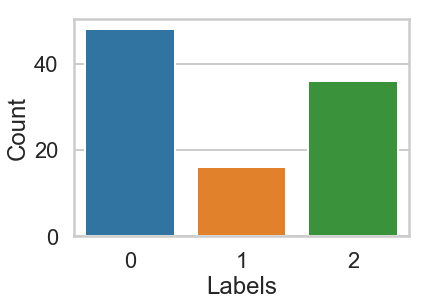

In [86]:
a3 = k_dict[3]
sns.countplot(a3)
plt.xlabel('Labels')
plt.ylabel('Count')

In [88]:
a3 = pd.DataFrame(a3)
a3.columns = ['Labels_pred']

In [89]:
joined_df_3_labels = pd.concat([new_d.reset_index(), a3[['Labels_pred']]],axis = 1)

In [90]:
joined_df_labels3_1 = joined_df_3_labels.loc[joined_df_3_labels.Labels_pred == 1] #Pandas dataframe with label 1
joined_df_labels3_2 = joined_df_3_labels.loc[joined_df_3_labels.Labels_pred == 2] #Pandas dataframe with label 2
joined_df_labels3_0 = joined_df_3_labels.loc[joined_df_3_labels.Labels_pred == 0] #Pandas dataframe with label 0

In [92]:
labels3_0_counts = {}
for j in range(1,33):
    if np.sum(joined_df_labels3_0[j])!= 0:
        labels3_0_counts[j] = np.sum(joined_df_labels3_0[j])

In [93]:
pd.DataFrame([labels3_0_counts]).stack().sort_values(ascending = False)

0  22    21.0
   31    17.0
   4     12.0
   11    12.0
   6     11.0
   9      9.0
   14     9.0
   1      9.0
   27     7.0
   20     6.0
   15     6.0
   28     5.0
   3      5.0
   25     5.0
   19     5.0
   5      4.0
   7      4.0
   2      4.0
   8      4.0
   32     4.0
   10     4.0
   23     4.0
   30     4.0
   12     3.0
   21     3.0
   26     3.0
   16     3.0
   18     1.0
   29     1.0
dtype: float64

In [102]:
df_offers.loc[(df_offers.offer_id == 22) | (df_offers.offer_id == 31) | (df_offers.offer_id == 4) | (df_offers.offer_id == 11) | (df_offers.offer_id == 6) | (df_offers.offer_id == 9) | (df_offers.offer_id == 14) | (df_offers.offer_id == 1) | (df_offers.offer_id == 27)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
8,9,April,Chardonnay,144,57,Chile,False
10,11,May,Champagne,72,85,France,False
13,14,June,Merlot,72,64,Chile,False
21,22,August,Champagne,72,63,France,False
26,27,October,Champagne,72,88,New Zealand,False
30,31,December,Champagne,72,89,France,False


**Label 0 indicates customers who purchased dry wine.**

In [103]:
labels3_1_counts = {}
for j in range(1,33):
    if np.sum(joined_df_labels3_1[j])!= 0:
        labels3_1_counts[j] = np.sum(joined_df_labels3_1[j])

In [104]:
pd.DataFrame([labels3_1_counts]).stack().sort_values(ascending = False)

0  26    12.0
   24    12.0
   17     7.0
   2      6.0
   27     1.0
   23     1.0
   16     1.0
   12     1.0
   10     1.0
   1      1.0
dtype: float64

In [106]:
df_offers.loc[(df_offers.offer_id == 26) | (df_offers.offer_id == 24) | (df_offers.offer_id == 17) | (df_offers.offer_id == 2)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


**Customers with label '2' purchased Pinot Noir.**

In [110]:
labels3_2_counts = {}
for j in range(1,33):
    if np.sum(joined_df_labels3_2[j])!= 0:
        labels3_2_counts[j] = np.sum(joined_df_labels3_2[j])

In [114]:
pd.DataFrame([labels3_2_counts]).stack().sort_values(ascending = False)

0  30    18.0
   8     16.0
   29    16.0
   7     15.0
   18    13.0
   13     6.0
   10     2.0
   21     1.0
   16     1.0
   25     1.0
   12     1.0
   11     1.0
   9      1.0
   27     1.0
   28     1.0
   6      1.0
   3      1.0
dtype: float64

In [115]:
df_offers.loc[(df_offers.offer_id == 30) | (df_offers.offer_id == 8) | (df_offers.offer_id == 7) | (df_offers.offer_id == 29) | (df_offers.offer_id == 18) | (df_offers.offer_id == 13)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
12,13,May,Merlot,6,43,Chile,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


# <font color=red >Classification summary with 3 labels </font>

**`Label 0`** - Customers purchased **`dry wine.`**

**`Label 1`** - Customers purchased **`Pinot Noir.`**

**`Label 2`** - Customers purchased wine varieties with **`min_qty = '6'`**

**Given below is the code that displays a plot of the centroids of the clusters for our originally chosen cluster size = 5.**

Automatically created module for IPython interactive environment
__________________________________________________________________________________


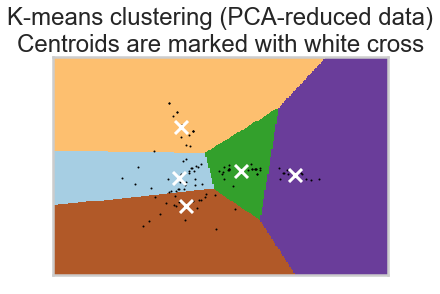

In [16]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

data = cust_data

n_samples, n_features = data.shape


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)


bench_k_means(KMeans(init='k-means++', n_clusters=5),
              name="k-means++", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=2).fit(cust_data)

print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(cust_data)
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

([<matplotlib.axis.XTick at 0x18dddff45f8>,
 <a list of 32 Text xticklabel objects>)

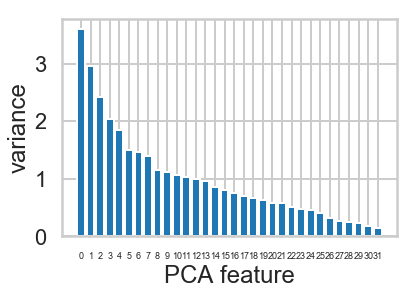

In [17]:
#your turn
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(cust_data)

# Plot the explained variances
features = range(pca.n_components_)
plt.rc('xtick', labelsize=9)
#rc('font', **font)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)

**From the explained variance plot above, we can make an estimation of the value of the "intrinsic" dimensionality of the dataset. That is, we do not need all the features to explain the variance in data. Data that could be considered as "noise" could be excluded from analysis. Additionally, this also helps with dimensionality reduction.**

**From the above plot, we could go with 8 as the "true" dimensionality.**

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn

In [116]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [119]:
X = cust_data
# Compute Affinity Propagation
model = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, preference=None, affinity='euclidean')
y_p = model.fit_predict(X)

In [20]:
np.unique(model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)

In [21]:
silhouette_score(X, y_p)

0.12346523604478911

**The affinity propagation algorithm came up with a PCA score of 0.123. However, ther are a total of 14 labels, which is not what we expected.**

Text(0.5, 1.0, 'Affinity Propagation')

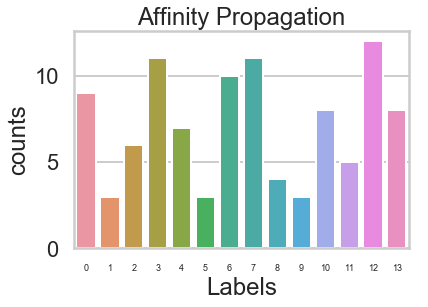

In [22]:
sns.countplot(model.labels_)
plt.xlabel('Labels')
plt.ylabel('counts')
plt.title('Affinity Propagation')

**From the plot above, we see the labels and their associated counts. Perhaps, some of the labels explain the variance in the same class which is not what we expected. Hence, we can safely say that this is perhaps not the best approach to the problem.**

**Let us now use spectral clustering to see if we can come up with a model that performs better.**

In [23]:
model1 = SpectralClustering(random_state=42, gamma=1.0)

In [24]:
y = model1.fit_predict(X)

In [25]:
silhouette_score(X, y)

0.077739004640547

**From the above model, we see that the model performed poorly with a silhouette score of just 0.077. Let us run this algorithm for various cluster sizes and see if it performs better.**

In [26]:
spectral_clust_dict = {}
for k in ks:
    model1 = SpectralClustering(random_state=42, gamma=1.0, n_clusters = k)
    y = model1.fit_predict(X)
    spectral_clust_dict[k] = silhouette_score(X, y)

**The spectral clustering has been applied for cluster sizes ranging from 2 through 10. The results are stored in a dictionary. Letus run it to see if we find any significant improvement in performance.**

In [27]:
spectral_clust_dict

{2: 0.07631909829627558,
 3: 0.10611539040197304,
 4: 0.08627893400734331,
 5: 0.09915711813463922,
 6: 0.09847779745663406,
 7: 0.07598262399017487,
 8: 0.077739004640547,
 9: 0.08714450020673453,
 10: 0.085809155141337}

**From the above dictionary, we see that none of the models performed significantly better. Hence, Spectral clustering isn't best fit for this model.**

In [28]:
model2 = AgglomerativeClustering(linkage='complete')
y2 = model2.fit_predict(X)

In [29]:
np.unique(model2.labels_)

array([0, 1], dtype=int64)

In [30]:
silhouette_score(X, y2)

0.2348896595208253

**By comuting the silhouette score, we see that Agglomerative clustering performed significantly better than the previous models. Let us look at the labels and their counts below.**

Text(0.5, 1.0, 'Agglomerative clustering')

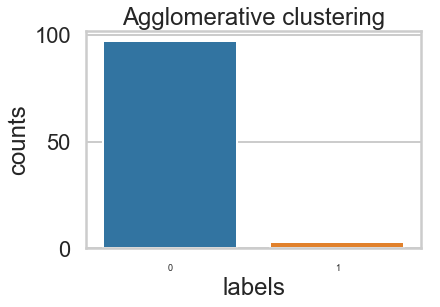

In [31]:
sns.countplot(model2.labels_)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Agglomerative clustering')

**What we see above probably isn't what we were expecting when we achieved that high sihouette score. We see that a vast majority of the labels have been assigned to a single label and hardly any at all for the other. As a last resort, let us try and run the alorithm once again for different cluster sizes using both complete and single linkage.**

In [71]:
linkages = ['complete', 'single']

In [77]:
aggl_clust_dict = {} #Dictionary to record the silhouette score of eah iteration
aggl_clust_labels_dict = {} #Dictionary to record the labels for each iteration
for k in ks:
    for links in linkages:
        model = AgglomerativeClustering(linkage=links, n_clusters = k)
        y2 = model2.fit_predict(X)
        aggl_clust_dict[str(k) + ' ' +links] = silhouette_score(X, y2)  
        aggl_clust_labels_dict[str(k) + ' ' +links] = model2.labels_

**Let us now observe the silhouette scores for each iteration and see if any of the models performed as per expectations.**

In [79]:
aggl_clust_dict

{'2 complete': 0.2348896595208253,
 '2 single': 0.2348896595208253,
 '3 complete': 0.2348896595208253,
 '3 single': 0.2348896595208253,
 '4 complete': 0.2348896595208253,
 '4 single': 0.2348896595208253,
 '5 complete': 0.2348896595208253,
 '5 single': 0.2348896595208253,
 '6 complete': 0.2348896595208253,
 '6 single': 0.2348896595208253,
 '7 complete': 0.2348896595208253,
 '7 single': 0.2348896595208253,
 '8 complete': 0.2348896595208253,
 '8 single': 0.2348896595208253,
 '9 complete': 0.2348896595208253,
 '9 single': 0.2348896595208253,
 '10 complete': 0.2348896595208253,
 '10 single': 0.2348896595208253}

**We see that none of the models performed significantly better. As a last try, let us try and plot the labels and their associated counts for our best value of k, which is 5.**

Text(0.5, 0, 'labels_complete')

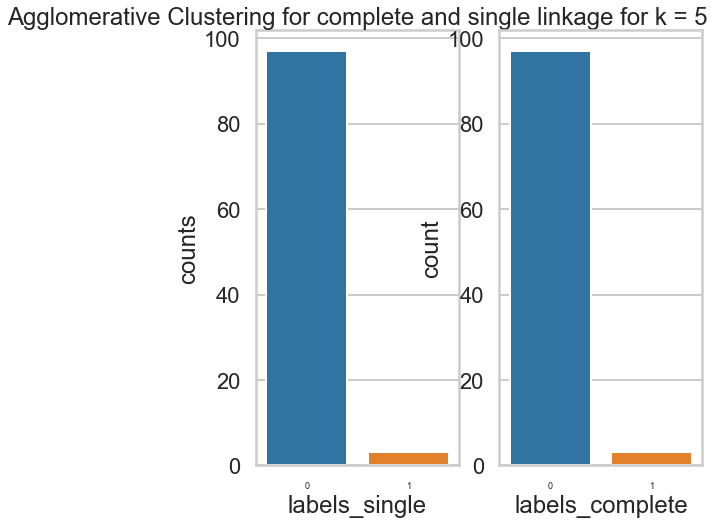

In [136]:
fig, ax = plt.subplots(figsize=(8,8))

plt.subplot(1,2,1)
sns.countplot(aggl_clust_labels_dict['5 single'])
plt.xlabel('labels_single')
plt.ylabel('counts')
plt.title('Agglomerative Clustering for complete and single linkage for k = 5')

plt.subplot(1,2,2)
sns.countplot(aggl_clust_labels_dict['5 complete'])
plt.xlabel('labels_complete')


**We see that the results were pretty much and the same and the clusters weren't grouped as expected.**

**Lastly, lt us try the DBSCAN clustering method.**

In [117]:
model3 = DBSCAN(eps = 1.5)

In [120]:
labels3 = model3.fit_predict(X)

Text(0.5, 1.0, 'DBSCAN')

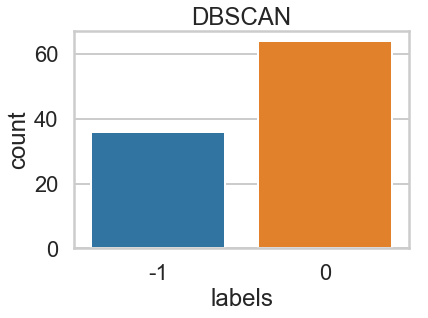

In [121]:
sns.countplot(model3.labels_)
plt.xlabel('labels')
plt.title('DBSCAN')

In [126]:
silhouette_score(X, model3.labels_)

0.11989886685810866

**For the DBSCAN clustering method, we need to iterate over different values of the 'eps' parameter which is "The maximum distance between two samples for them to be considered as in the same neighborhood." The model performs decently for eps = 1.5 and see that the counts for each label aren't as imbalanced as before.**

**In terms of the silhouette score, affinity propagation comes close. However, the model predicted too many labels and hence, we can make the case that DBSCAN() performs best here.**

In [1]:
#------------------------------------------------DONE------------------------------------------------#